![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)
# Introduction
This notebook contains a detailed EDA and a couple of baseline models for the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition, the **regression** cousin for beginners of the [Titanic](https://www.kaggle.com/c/titanic).  
This dataset is perfect for experimenting with a lot of techniques and strengthening your knowledge: we are asked to predict the final price of 1459 houses given 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.  
With missing values to impute properly, a ton of categorical columns to deal with, and the possibility to practice creative feature engineering, we have a long way to go before we deploy a reasonable model.  
Without further ado, let's get started!

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from scipy import stats

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter('ignore')
print('Setup complete')

Let's take a look at the first five rows of the training set: we already see some missing values and that we have an `Id` column that is not useful for predictions.  
The target `SalePrice` is the last column and it will not be present in the test set that will thus have 80 columns only. 

In [ ]:
# Read data
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train.head()

Now we will introduce a couple of functions that will be used frequently in the EDA part.  
The first one plots numerical variables (scatterplot or stripplot with the target `SalePrice` & the variable distribution), the latter plots categorical variables (stripplot & boxplot).

In [ ]:
def plot_numerical(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' analysis')

def plot_categorical(col):
    fig, ax = plt.subplots(1,2,figsize=(12,6), sharey=True)
    sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
    sns.boxplot(x=col, y='SalePrice', data=train, ax=ax[1])
    fig.suptitle(str(col) + ' analysis')
    
print('plot_numerical() & plot_categorical() are ready to use')

# The target variable Saleprice
As you can see below, the sale prices are right-skewed: this was somewhat expected as few people can afford very expensive houses.  
The two vertical lines are the first and third quartiles: we see that the core of the distribution is in a `SalePrice` range between 129975 and 214000.  
For the moment, let's keep this in mind: we will eventually normalize before modeling.

In [ ]:
plt.figure(figsize=(8,5))
a = sns.distplot(train.SalePrice, kde=False)
plt.title('SalePrice distribution')
a = plt.axvline(train.SalePrice.describe()['25%'], color='b')
a = plt.axvline(train.SalePrice.describe()['75%'], color='b')
print('SalePrice description:')
print(train.SalePrice.describe().to_string())

# Best numerical feature analysis
Since it is not the case to plot all the features, one thing we can do is actually taking a look at some of the most predictive ones using a model-based selection.  
We will start by analyzing the numerical columns, using an ExtraTreesRegressor to have an idea.  
I want to mention that if you change the model, you will surely see a different feature importance plot due to the way it is built, but the result you'll get will be similar if the models have the same architecture.

In [ ]:
# Select numerical features only
num_features = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
# Remove Id & SalePrice 
num_features.remove('Id')
num_features.remove('SalePrice')
# Create a numerical columns only dataframe
num_analysis = train[num_features].copy()
# Impute missing values with the median just for the moment
for col in num_features:
    if num_analysis[col].isnull().sum() > 0:
        num_analysis[col] = SimpleImputer(strategy='median').fit_transform(num_analysis[col].values.reshape(-1,1))
# Train a model   
clf = ExtraTreesRegressor(random_state=42)
h = clf.fit(num_analysis, train.SalePrice)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,num_features)), columns=['Value','Feature'])
plt.figure(figsize=(16,10))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.title('Most important numerical features with ExtraTreesRegressor')
del clf, h;

I think looking at the first eight features is enough to understand the data.  
First, let's see the correlation heatmap between these columns and the target as some of them are likely to be correlated.

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Correlation matrix with SalePrice')
selected_columns = ['OverallQual', 'GarageCars', 'GrLivArea', 'YearBuilt', 'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageArea']
a = sns.heatmap(train[selected_columns + ['SalePrice']].corr(), annot=True, square=True)

We notice a strong positive correlation between `GarageArea` and `GarageCars`, as well as between `1stFlSF` and `TotalBsmtSF`.  
Some of the variables are also well correlated with the target, even though some non-linear relationships may be hidden in the data.  
Let's proceed with the analysis of one feature at a time.
## OverallQual
This feature is the most correlated to the target (0.79) when we search for linear relationships and also by far the most predictive according to our tree-based model.    
As the data description says, `OverallQual` rates the overall material and finish of the house on a scale from 1 to 10.  
Let's see what we are talking about.

In [ ]:
plot_numerical('OverallQual', True)

We notice a very nice trend, with the minimum generally increasing.  
However, when `OverallQual` is ten, we have two very cheap houses: these are definitely outliers that we should remove later.
## GarageCars
No, they are not giving you a car inside the garage when you buy a house!  
This variable is just a way of measuring the size of the garage but in car capacity.  
It has actually a slightly better correlation (0.64) with the target than `GarageArea`, even though the values are discrete.

In [ ]:
plot_numerical('GarageCars', True)

We see the houses with a `GarageCars` value of 4 have all low prices, really particular.  
For the rest, the trend looks nice: having a `GarageCars` value of 3 seems the standard for very expensive homes with no exceptions.
## GrLivArea
This value represents the above grade (ground) living area in square feet of the house and it is one of the most common measures people consider when buying.  
With no surprise, the correlation of this feature with `SalePrice` is 0.71, even though we notice two bad outliers on the bottom-right that should be removed.

In [ ]:
plot_numerical('GrLivArea')

## YearBuilt
This column is just the original construction date of the house and it is self-explanatory.  
Let's plot it and we will make some considerations later.

In [ ]:
plot_numerical('YearBuilt')

We see that more recent houses generally have a higher price and the trend looks actually quadratic to me, but I may be tricked by the plot.  
Even though there are some historical houses with a medium-high price, we see that when we talk about expensive houses (>400k) they are all built in the last 20 years except one.  
We also see that the minimum price for a house is increasing after the second post-war period with a fairly robust trend.
## FullBath
This column indicates the total number of full bathrooms above grade.  
Its values are discrete and it is the fifth variable by importance in our tree model.

In [ ]:
plot_numerical('FullBath', True)

The trend looks good, but there are actually not many houses with 0 or 3 bathrooms, so it's a bit tricky.
## 1stFlrSF
This column tells us the size of the first floor in square feet and it totally makes sense that is important for our tree model.  
It has a correlation with `SalePrice` of 0.61 too, which is not bad.  
If we want to tell all the truth, this variable is partially redundant as incorporated in `GrLivArea`, but it still plays an important role.  
We note that the two outliers are present also here and are the same as before.

In [ ]:
plot_numerical('1stFlrSF')

## TotalBsmtSF
This column contains the total square feet of the basement area.  
It has a very respectable correlation with the target of 0.61 and is the seventh most important variable for our model.  
Here is the plot: of course, this time, we have some zero values because not every house has a basement.  
It seems like multiple outliers are present also here...

In [ ]:
plot_numerical('TotalBsmtSF')

## GarageArea
This is the last numerical variable we are looking at.  
The column name speaks for itself, so let's just see the plot and the correlation of 0.62 with the target `SalePrice`.  
According to our model, this variable is four times less important than `GarageCars`, so it seems like the other garage feature is more informative.  
Also this time, multiple zero values are present as not all houses have a garage.

In [ ]:
plot_numerical('GarageArea')

We spot four outliers on the right, but also the super expensive houses are really far from the regression line.  
The feature is also not normally distributed but has three (or four?) peaks.  
Let's wrap this part up and move to analyze some categorical variables: I don't want to make the notebook excessively long and provide no useful information. 
# Best categorical feature analysis
In this section, we will analyze some of the most useful categorical variables.  
We still have missing values to impute and also we have to encode the columns such that a model can use them, so for now I will impute everything with a NA label and use target encoding.

In [ ]:
# Select categorical features only
cat_features = [col for col in train.columns if train[col].dtype =='object']
# Create a categorical columns only dataframe
cat_analysis = train[cat_features].copy()
# Impute missing values with NA just for the moment
for col in cat_analysis:
    if cat_analysis[col].isnull().sum() > 0:
        cat_analysis[col] = SimpleImputer(strategy='constant').fit_transform(cat_analysis[col].values.reshape(-1,1))
# Target encoding
target_enc = TargetEncoder(cols=cat_features)
cat_analysis = target_enc.fit_transform(cat_analysis, train.SalePrice) 
# Train a model 
clf = ExtraTreesRegressor(random_state=42)
h = clf.fit(cat_analysis, train.SalePrice)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cat_features)), columns=['Value','Feature'])
plt.figure(figsize=(16,10))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.title('Most important categorical features with ExtraTreesRegressor')
del clf, h;

We will take a look at the four most useful categorical variables to complete our preliminary EDA and understand if they can really help our model or not.  
## Neighborhood
This column represents the physical locations within Ames city limits and it is the most useful categorical variable according to our model.  
I guess that's because there are obviously areas in the city that are particularly wealthy or deprived.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,6), sharey=True)
sns.stripplot(x='Neighborhood', y='SalePrice', data=train, ax=ax[0])
sns.boxplot(x='Neighborhood', y='SalePrice', data=train, ax=ax[1])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
fig.suptitle('Neighborhood analysis')
plt.show()

Alongside some rare occurrences, from the plot we clearly see some neighborhoods as NridgHt, Blmngtn, Veenker, StoneBr, NoRidge where the baseline price for a house is over 150000.
## ExterQual
The column name is quite self-explanatory as this variable describes the quality of the material on the exterior.  
It is an ordinal variable with 
```
Ex	Excellent
Gd	Good
TA	Average/Typical
Fa	Fair
Po	Poor
```
and that's exactly what we see in the plots, even if there are multiple outliers present.  
Note that for every value the interquartile ranges are not overlapping: this is something that will eventually become false while we proceed in this analysis.

In [ ]:
plot_categorical('ExterQual')

## BsmtQual
This variable evaluates the height of the basement and it is ordinal with
```
Ex	Excellent (100+ inches)	
Gd	Good (90-99 inches)
TA	Typical (80-89 inches)
Fa	Fair (70-79 inches)
Po	Poor (<70 inches)
```
We see the trend is correct from the boxplots, so there's nothing to point out here.

In [ ]:
plot_categorical('BsmtQual')

## KitchenQual
Wow, have you ever thought about this variable being a really important one?  
That's a bit weird, but having a nice looking kitchen actually seems a sign of an expensive house.  
Again, the variable is ordinal with 
```
Ex	Excellent
Gd	Good
TA	Typical/Average
Fa	Fair
Po	Poor
```  

In [ ]:
plot_categorical('KitchenQual')

We are done with this part, let's move on to filling missing values. 
# Dealing with missing values
Let's start by counting the percentage of missing values in the various columns for both train and test data.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,6), sharey=True)
train_missing = round(train.isnull().mean()*100, 2)
train_missing = train_missing[train_missing > 0]
train_missing.sort_values(inplace=True)
sns.barplot(train_missing.index, train_missing, ax=ax[0], color='orange')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylabel('Percentage of missing values')
ax[0].set_title('Train set')
test_missing = round(test.isnull().mean()*100, 2)
test_missing = test_missing[test_missing > 0]
test_missing.sort_values(inplace=True)
sns.barplot(test_missing.index, test_missing, ax=ax[1], color='orange')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Test set')
plt.show()

We see that there are more columns with missing values in the test set, but most of them have very few missing entries which is a good thing.  
Apart from that, we recognize the same structure of the train data: we have a small number of missing values in the basement features, a greater amount in the garage features, and around 15% of data is missing in the `LotFrontage` column.  
We then have `FireplaceQu` with around 50% of missing values and four columns with more than 80% of missing values.  
Before imputing or deleting these columns, let's take a moment to figure out why the data is missing in the columns with a non-negligible amount of null entries.  
## Basement and Garage variables
From the data description, we see that null values in both basement and garage columns happen because a house does not have these ambients, so the correct way to impute them is not with the most common value but with a missing label (if categorical) or with a new value (if numerical).
## LotFrontage
What about `LotFrontage`? It should represent the linear feet of the street connected to the property, so a missing value could happen because it was not recorded.  
Let's plot it so we can understand better if that's the case or not.

In [ ]:
plot_numerical('LotFrontage')
print('LotFrontage minimum:', train.LotFrontage.min())

We notice that the minimum value for `LotFrontage` is 21, so null values could also stand for 0 (=not present)!  
However, due to zero values in other numerical features as `TotalBsmtSF` or `GarageArea` when they were not present, I think these values are missing because they were not recorded.  
Since we have a lot of other columns to work with, filling with the median or mean would definitely be a coarse approach, even though this variable was not used much by our tree model in the previous section.  
For this reason, we will use sklearn's KNNImputer which will probably give better results.
## FireplaceQu
This column indicates the fireplace quality.  
Similar to other features, we know these values are missing because a fireplace is not present in the house so the right way to impute this column is with a missing label.  
I said impute and not drop because this feature was actually pretty important according to our tree-based model (it was the fifth most predictive variable), so it's a pity to delete it.  
This variable is supposed to be ordinal with 
```
Ex	Excellent - Exceptional Masonry Fireplace
Gd	Good - Masonry Fireplace in main level
TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
Fa	Fair - Prefabricated Fireplace in basement
Po	Poor - Ben Franklin Stove
NA	No Fireplace
```
and we can clearly recognize the order despite the presence of multiple outliers.

In [ ]:
plot_categorical('FireplaceQu')

## Fence, Alley, MiscFeature, PoolQC
All these columns have more than 80% of missing values and in every case because the attribute they are describing is not present in the house.  
Unlike the `FireplaceQu` feature, all these variables filled with a missing label were not used a lot by the model, so they should be not very informative.  
For completeness, we still analyze them to understand why this happens.

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,10), sharey=True)
sns.stripplot(x='Fence', y='SalePrice', data=train, ax=ax[0][0])
sns.stripplot(x='Alley', y='SalePrice', data=train, ax=ax[0][1])
sns.stripplot(x='MiscFeature', y='SalePrice', data=train, ax=ax[1][0])
sns.stripplot(x='PoolQC', y='SalePrice', data=train, ax=ax[1][1])
fig.suptitle('Analysis of columns with more than 80% of missing values')
plt.show()

We see there's nothing particularly interesting going on here: either the number of samples with non-null entries is too low to extract a meaningful pattern or the points overlap in a price range that's also extremely dense of houses.
## Fill missing values
As described earlier, we now proceed with the column imputation: we will fill all columns with a low percentage of missing values with the most common one, `LotFrontage` using KNNImputer on `LotArea` (which appears to have a nice correlation with it) and the rest with NAs.

In [ ]:
# Fill high % missing columns with NA
for col in ['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']:
    train[col].fillna('NotAvailable', inplace=True)
    test[col].fillna('NotAvailable', inplace=True)
    
# Fill Garage variables with NA
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[col].fillna('NotAvailable', inplace=True)
    test[col].fillna('NotAvailable', inplace=True)
    
# Fill GarageYrBlt with a new value
# I chose the min over train + test set minus 1
garage_min = min(train['GarageYrBlt'].min(), test['GarageYrBlt'].min()) -1
train['GarageYrBlt'].fillna(garage_min, inplace=True)
test['GarageYrBlt'].fillna(garage_min, inplace=True)

# Fill these Garage columns with 0
for col in ['GarageArea', 'GarageCars']:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)
    
# Fill numerical Bsmt variables with 0
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)
    
# Fill categorical Bsmt variables with NA  
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train[col].fillna('NotAvailable', inplace=True)
    test[col].fillna('NotAvailable', inplace=True)
    
# Fill low % missing columns with the mode
for col in ['MasVnrType', 'MSZoning', 'Functional', 'Electrical', 'KitchenQual', 'Exterior1st',
           'Exterior2nd', 'SaleType','MSSubClass', 'Utilities', 'MasVnrArea']:
    imputer = SimpleImputer(strategy='most_frequent')
    train[col] = imputer.fit_transform(train[col].values.reshape(-1,1))
    test[col] = imputer.transform(test[col].values.reshape(-1,1))
    
# Fill LotFrontage with KNNImputer on LotArea
imputer = KNNImputer(n_neighbors=5)
train[['LotFrontage', 'LotArea']] = imputer.fit_transform(train[['LotFrontage', 'LotArea']])
test[['LotFrontage', 'LotArea']] = imputer.transform(test[['LotFrontage', 'LotArea']])

print('Imputation finished!')
print('Number of missing values in the train set:', train.isnull().sum().sum())
print('Number of missing values in the test set:', test.isnull().sum().sum())

# Feature selection
Now that we have all the missing values imputed, we still have 79 explanatory variables and we should definitely make a selection to reduce the dimensionality of the dataset.  
As we did before, let's train an ExtraTreesRegressor to see the most important numerical and categorical variables combined: we will keep the features whose importance is greater than a certain threshold.  
After a quick analysis, I decided to treat `MSSubClass`, `MoSold`, `YrSold` as categorical from now on because they are of int/float type but they are not ordinal.

In [ ]:
# Select categorical features
cat_features = [col for col in train.columns if train[col].dtype =='object']
cat_features = cat_features + ['MSSubClass','MoSold','YrSold']
# Select numerical features
num_features = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in cat_features]
# Remove Id & SalePrice 
num_features.remove('Id')
num_features.remove('SalePrice')
# Encode categorical features
target_enc = TargetEncoder(cols=cat_features)
train_TE = train[num_features].join(target_enc.fit_transform(train[cat_features], train.SalePrice)) 
# Train a model
clf = ExtraTreesRegressor(random_state=0)
h = clf.fit(train_TE, train.SalePrice)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,train_TE)), columns=['Value','Feature'])
plt.figure(figsize=(20,14))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.title('Feature importance with ExtraTreesRegressor')
del clf, h;

I think deleting the least used columns will only help, so we will reduce the dimensionality of the data to 60 features and leave the rest of the work to the models themselves.

In [ ]:
cols_to_keep = list(feature_imp.sort_values(by='Value', ascending=False).reset_index(drop=True).loc[:59, 'Feature'])
print('Keeping the first {:d} most informative features'.format(len(cols_to_keep)))

# Remove outliers?
As we saw in the previous sections, there are some outliers in the most predictive features as well as in the less predictive ones.  
Here I plotted some examples: we can see that large values of the features do not lead to an increase in `SalePrice`, but also that really high values of the target are some sort of outliers equally.  
What should we do?

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,10), sharey=True)
plt.suptitle('Outliers analysis')
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, ax=ax[0][0])
sns.scatterplot(x='OverallQual', y='SalePrice', data=train, ax=ax[0][1])
sns.scatterplot(x='LotFrontage', y='SalePrice', data=train, ax=ax[1][0])
a = sns.scatterplot(x='LotArea', y='SalePrice', data=train, ax=ax[1][1])

After some tests, I decided not to delete them forever but just in the training phase: we will see in a moment that in the validation part they give us the possibility to understand some errors and actively correct them to increase the model performances.  
So, let's just save their `Id` for now.

In [ ]:
outliers_id = set(train.loc[train.GrLivArea > 4500, 'Id']) 
print('Outliers saved in outliers_id')

# Understand the competition metric
The metric for this competition (read [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation)) is Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price, much better known as Root-Mean-Squared-Log-Error (RMSLE).  
If $p_i$ and $a_i$ are respectively the $i$-th predicted and actual price of a house, the RMSLE of the submission will be
$$ 
\text{RMSLE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}{(\log{p_i}-\log{a_i})}^2}
$$
Because most classifiers cannot minimize this metric by default and we have to define a custom one, we can kill two birds with one stone and take the log of `SalePrice` before training our model.  
Not only this will give us the possibility to use MSE/RMSE as a metric (taking the square root doesn't make any difference), but it will also transform the target distribution to look like a normal one avoiding further problems.

In [ ]:
# Applies log to all elements of the target column
y_train = train.loc[~train.Id.isin(outliers_id), 'SalePrice'].apply(lambda x: np.log(x)).reset_index(drop=True)
# Plot the difference
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Log transformed SalePrice')
sns.distplot(y_train, fit=stats.norm)
#Getting the parameters used by the function
(mu, sigma) = stats.norm.fit(y_train)
plt.legend(['Normal distr. ($\mu=${:.2f}, $\sigma=${:.2f})'.format(mu, sigma)])
plt.ylabel('Density')
#QQ-plot
plt.subplot(1, 2, 2)
a = stats.probplot(y_train, plot=plt)

# Model training
For this competition, my approach was building two different models (Lasso & LightGBM), analyze their errors, correct them if necessary, and finally create an ensemble.  
This is way better than training only one model because averaging reduces a lot of the error and gives the possibility to go well under 0.12000 in the LB, something that for a single model is a bit difficult.
## Lasso
We start with a regularized linear model, and since some features are very well correlated with the target, it should do very well.  
Our preprocessing pipeline consists of a normalizer for the numerical columns and one-hot-encoding for the categorical attributes.

In [ ]:
# Define the train set
X_train = train.loc[~train.Id.isin(outliers_id), cols_to_keep].reset_index(drop=True)
X_test = test[cols_to_keep]
# Intersect cat_features and cols_to_keep
cat_cols = [col for col in cols_to_keep if col in cat_features]
# Intersect num_features and cols_to_keep
num_cols = [col for col in cols_to_keep if col not in cat_features]

# Lasso preprocessing 
lasso_preprocessor = ColumnTransformer(transformers=[
        ('num', PowerTransformer(standardize=True), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

Now we can validate our Lasso model using 5-fold cross-validation and extract the out of fold (OOF) predictions as explained [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175614) to understand where it is wrong.

In [ ]:
oof_lasso = np.zeros(len(X_train))
preds_lasso = np.zeros(len(X_test))
out_preds_lasso = np.zeros(2)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
print('Training {:d} Lasso models...\n'.format(kf.n_splits))

for i, (idxT, idxV) in enumerate(kf.split(X_train, y_train)):
    print('Fold', i)
    print(' rows of train =', len(idxT),'rows of holdout =', len(idxV))
  
    train_prep = lasso_preprocessor.fit_transform(X_train.loc[idxT])
    valid_prep = lasso_preprocessor.transform(X_train.loc[idxV])
    out_prep = lasso_preprocessor.transform(train.loc[train.Id.isin(outliers_id), cols_to_keep])
    test_prep = lasso_preprocessor.transform(X_test)
    
    clf = Lasso(alpha=0.0005)
    h = clf.fit(train_prep, y_train.loc[idxT])
    
    oof_lasso[idxV] += clf.predict(valid_prep)
    out_preds_lasso += clf.predict(out_prep)/kf.n_splits
    preds_lasso += clf.predict(test_prep)/kf.n_splits
    
    del h, clf
    
print ('\nOOF CV:', mean_squared_error(y_train, oof_lasso, squared=False))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].set_title('Lasso OOF predictions vs real SalePrice')
ax[0].set_xlabel('OOF predictions')
sns.scatterplot(np.exp(oof_lasso), np.exp(y_train), ax=ax[0])
x = np.linspace(0,700000, 100)
ax[0].plot(x, x, 'r-', lw=1)
# Residuals plot
ax[1].set_title('Residuals')
sns.scatterplot(x=np.exp(oof_lasso), y=np.exp(y_train)-np.exp(oof_lasso), ax=ax[1])
ax[1].set_ylabel('SalePrice - OOF predictions')
ax[1].set_xlabel('OOF predictions')
plt.show()

We see that the Lasso model is pretty good and that most of the points are really close to the red diagonal line where they should be.  
The residuals plot looks also not bad: the model makes just a few large errors and the point cloud is almost symmetric.  
Now, let's consider another important aspect which is the behavior of the model when encountering the outliers we set aside earlier: they were not used for training but we still have their predicted values for a quick comparison.  
In the train set, when `GrLivArea` passes 4500, the `SalePrice` drops for some reason and we will see in a moment that our linear model makes huge errors in these cases.  
In the test set we are lucky: there is only a house with `GrLivArea` over 5000 and I am pretty confident its price will be below 200k.

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train vs predictions comparision')
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, label='Real train')
sns.scatterplot(x=train.loc[train.Id.isin(outliers_id), 'GrLivArea'], y = np.exp(out_preds_lasso), label='Outliers predictions')
a = sns.scatterplot(test.GrLivArea, np.exp(preds_lasso), label='Test predictions')

The blue and yellow clouds are perfectly stackable: the predictions for the test set are well aligned with the train one.  
Now we focus our attention on the two red dots: the linear model predicted a really high `SalePrice` for them (over a milion!) but they should be much lower in the plot.  
In the same zone, we spot a yellow prediction for the test set: I bet its value should be much lower as well.  
We will thus proceed with changing this prediction and have our final Lasso submission ready.

In [ ]:
lasso_submission = np.exp(preds_lasso)
lasso_submission[1089] = train.loc[train.GrLivArea>4500, 'SalePrice'].mean()

## LigthGBM
Now, let's train a tree-based model: this time, our preprocessing pipeline does not modify the numerical columns and applies target encoding for the categorical attributes.  
This variety should definitely help to make different errors.

In [ ]:
tree_preprocessor = ColumnTransformer(transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', TargetEncoder(cols=cat_cols), cat_cols)
])

Again, we can validate our model using 5-fold cross-validation (with the same random seed as before, so they are exactly the same folds) and extract the out of fold predictions so we can ensemble the two models later.

In [ ]:
oof_LGBM = np.zeros(len(X_train))
preds_LGBM = np.zeros(len(X_test))
out_preds_LGBM = np.zeros(2)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
print('Training {:d} LGBM models...\n'.format(kf.n_splits))

for i, (idxT, idxV) in enumerate(kf.split(X_train, y_train)):
    print('Fold', i)
    print(' rows of train =', len(idxT),'rows of holdout =', len(idxV))
  
    train_prep = tree_preprocessor.fit_transform(X_train.loc[idxT], y_train.loc[idxT])
    valid_prep = tree_preprocessor.transform(X_train.loc[idxV])
    out_prep = tree_preprocessor.transform(train.loc[train.Id.isin(outliers_id), cols_to_keep])
    test_prep = tree_preprocessor.transform(X_test)
    
    clf = LGBMRegressor(n_estimators=5000, random_state=42, num_leaves=8, colsample_bytree=0.8)
    h = clf.fit(train_prep, y_train.loc[idxT], 
                eval_set=[(valid_prep, y_train.loc[idxV])],
                verbose=300, early_stopping_rounds=200, eval_metric='rmse')
    
    oof_LGBM[idxV] += clf.predict(valid_prep)
    out_preds_LGBM += clf.predict(out_prep)/kf.n_splits
    preds_LGBM += clf.predict(test_prep)/kf.n_splits
    
    del h, clf
    
print ('\nOOF CV', mean_squared_error(y_train, oof_LGBM, squared=False))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].set_title('LGBM OOF predictions vs SalePrice')
ax[0].set_xlabel('OOF predictions')
sns.scatterplot(np.exp(oof_LGBM), np.exp(y_train), ax=ax[0])
x = np.linspace(0,650000, 100)
ax[0].plot(x, x, 'r-', lw=1)
# Residuals plot
ax[1].set_title('Residuals')
sns.scatterplot(x=np.exp(oof_LGBM), y=np.exp(y_train)-np.exp(oof_LGBM), ax=ax[1])
ax[1].set_ylabel('SalePrice - OOF predictions')
ax[1].set_xlabel('OOF predictions')
plt.show()

We see that the LGBM model is very similar to the Lasso one, but seems to make larger errors from the point cloud.  
Let's see how it behaves when it encounters the outliers.

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train vs predictions comparision')
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, label='Real train')
sns.scatterplot(x=train.loc[train.Id.isin(outliers_id), 'GrLivArea'], y = np.exp(out_preds_LGBM), label='Outliers predictions')
a = sns.scatterplot(test.GrLivArea, np.exp(preds_LGBM), label='Test predictions')

Again the blue and yellow clouds are perfectly stackable as they should be, but the two red dots are another time overestimated (less than before though).  
For this reason, we will proceed with changing the yellow outlier prediction and have our final LGBM submission ready.

In [ ]:
LGBM_submission = np.exp(preds_LGBM)
LGBM_submission[1089] = train.loc[train.GrLivArea>4500, 'SalePrice'].mean()

## Ensemble using OOF predictions
We now proceed with the ensemble procedure: we loop through all 101 weights from 0.00 to 1.00 and search for the one that minimizes the weighted RMSLE of the two OOF predictions.  
Once we find it, it will be used to create a weighted submission file that should reflect the nice behavior of the OOF CV.  
To fully understand this code, I link again to this beautiful [discussion](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175614) by Chris Deotte which focuses very well on this method.

In [ ]:
all = []
for w in np.linspace(0,1,101):
    ensemble_pred = w * oof_lasso + (1-w) * oof_LGBM
    ensemble_rmsle = mean_squared_error(ensemble_pred, y_train, squared=False)
    all.append(ensemble_rmsle)
# Print the best weight
best_weight = np.argmin(all)/100
print('Best weight =', best_weight)
# Plot the ensemble_rmsle against w
plt.figure(figsize=(8,5))
plt.title('Ensemble RMSLE against weight $w$')
plt.xlabel('$w$')
plt.ylabel('Ensemble RMSLE')
a = sns.scatterplot(x=np.linspace(0,1,101), y=all, color='orange')
plt.legend(['$w\cdot$oof_lasso + $(1-w)\cdot$oof_LGBM'])
plt.show()

Wow, we see a nice parabola, which means great success on our side.  
Once we weight the predictions as well, we are ready to submit and climb the LB to the top!

In [ ]:
kaggle_sub = best_weight*lasso_submission + (1-best_weight)*LGBM_submission
# Save the output
output = pd.DataFrame({'Id': test.Id, 'SalePrice': kaggle_sub})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')

# Conclusion
First of all, thank you for reading my notebook: feel free to leave a comment if something isn't clear, I'm always trying to improve!  
That being said, I am very happy to reach the top of the LB also in this competition: surely it is possible to lower the MSLE again by ensembling more models, but I think the simplicity and effectiveness of this solution are fascinating.  
Here is a histogram of House Prices LB scores in November 2020: you can see that our score of 0.11635 places between the orange and red line and it is pretty good (top 3%)! 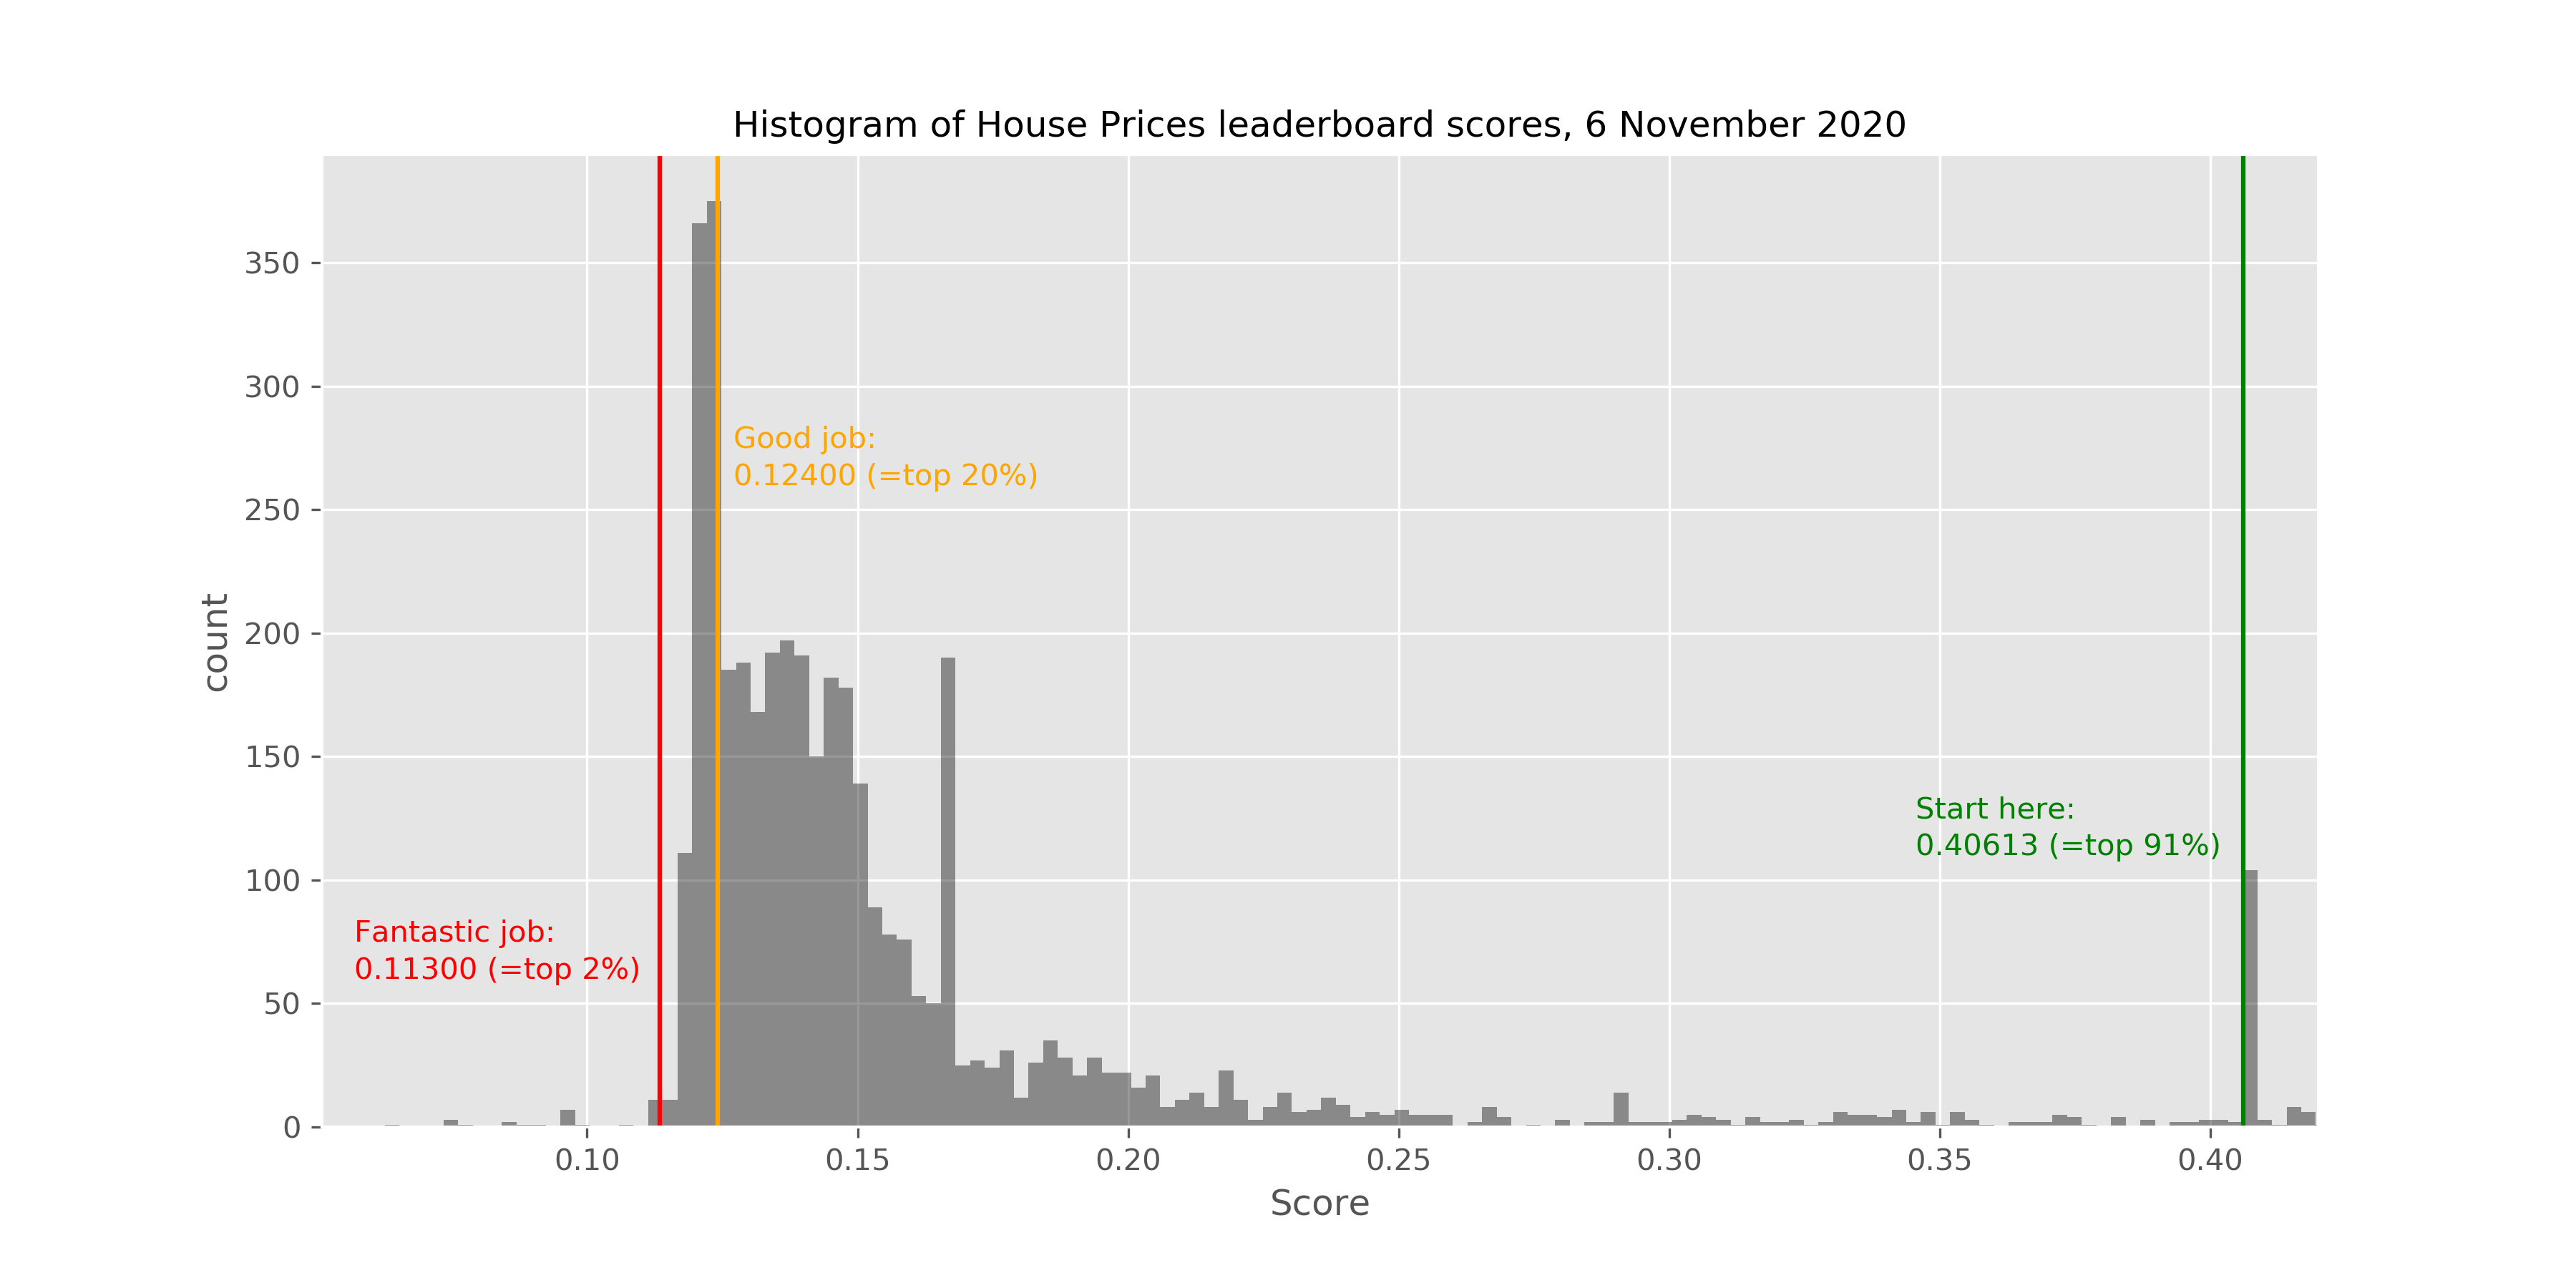
As always, I learned a lot also from this experience, but now it's time to move on: see you in the next one and have a nice day!